In [1]:
import numpy as np
import pandas as pd
import datetime
import os
import shutil
import re
import math
import matplotlib.pyplot as plt
import skimage
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage import img_as_float32, img_as_ubyte, img_as_float64
import pickle
import cv2

from albumentations import (
    Compose, HorizontalFlip, ShiftScaleRotate, ElasticTransform,
    RandomBrightness, RandomContrast, RandomGamma
)

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)
    
    
img_size = 400

## Functions

In [2]:
reduce_learning_rate = keras.callbacks.ReduceLROnPlateau(
  monitor = "loss", 
  factor = 0.5, 
  patience = 3, 
  verbose = 1
)

checkpointer = keras.callbacks.ModelCheckpoint(
  "unet.h5", 
  verbose = 1, 
  save_best_only = True
)

# LOSS Functions
def jaccard_distance_loss(y_true, y_pred, smooth = 100):
    intersection = keras.backend.sum(keras.backend.abs(y_true * y_pred), axis = -1)
    union = keras.backend.sum(keras.backend.abs(y_true) + keras.backend.abs(y_pred), axis = -1)
    jac = (intersection + smooth) / (union - intersection + smooth)
    loss = (1 - jac) * smooth
    return loss

def dice_coef(y_true, y_pred, smooth = 1):
    intersection = keras.backend.sum(keras.backend.abs(y_true * y_pred), axis = -1)
    union = keras.backend.sum(keras.backend.abs(y_true), -1) + keras.backend.sum(keras.backend.abs(y_pred), -1)
    return (2. * intersection + smooth) / (union + smooth)

## Load Unet

In [3]:
if (os.path.exists("unet.h5")):
  model = keras.models.load_model("unet.h5",
    custom_objects = {
      "jaccard_distance_loss": jaccard_distance_loss,
      "dice_coef": dice_coef
    }
  )
  

## Metrics

In [4]:
X_val = np.load('input/X_val.npy')
Y_val = np.load('input/Y_val.npy')


with open('input/epochs.txt', 'r') as file:
    steps_per_epoch = file.read().rstrip()

steps_per_epoch = int(steps_per_epoch)


In [5]:
X_val[0].shape

(400, 400, 1)

In [6]:
iou_val, dice_val = model.evaluate(X_val, Y_val, verbose = False)


In [7]:
X_train = np.load('input/X_train.npy')
Y_train = np.load('input/Y_train.npy')


iou_train, dice_train = model.evaluate(X_train, Y_train, verbose = False)


In [8]:
X_test = np.load('input/X_test.npy')
Y_test = np.load('input/Y_test.npy')


iou_test, dice_test = model.evaluate(X_test, Y_test, verbose = False)



In [9]:
print("Jaccard distance (IoU) train: %f" % iou_train)
print("Dice coeffient train: %f" % dice_train)
print("Jaccard distance (IoU) validation: %f" % iou_val)
print("Dice coeffient validation: %f" % dice_val)
print("Jaccard distance (IoU) test: %f" % iou_test)
print("Dice coeffient test: %f" % dice_test)

Jaccard distance (IoU) train: 0.034742
Dice coeffient train: 0.982193
Jaccard distance (IoU) validation: 0.032761
Dice coeffient validation: 0.983187
Jaccard distance (IoU) test: 0.028160
Dice coeffient test: 0.985509


In [10]:
nimages = X_train.shape[0]
iou_train = []
dice_train = []
for idx in range(nimages):
  iou, dice = model.evaluate(X_train[idx:idx+1,:,:], Y_train[idx:idx+1,:,:], verbose = False)
  iou_train.append(iou)
  dice_train.append(dice)

print("Jaccard distance (IoU) train: %f (+-%f)" % (np.mean(iou_train), np.std(iou_train)))
print("Dice coeffient train: %f (+-%f)" % (np.mean(dice_train), np.std(dice_train)))

nimages = X_val.shape[0]
iou_val = []
dice_val = []
for idx in range(nimages):
  iou, dice = model.evaluate(X_val[idx:idx+1,:,:], Y_val[idx:idx+1,:,:], verbose = False)
  iou_val.append(iou)
  dice_val.append(dice)

print("Jaccard distance (IoU) validation: %f (+-%f)" % (np.mean(iou_val), np.std(iou_val)))
print("Dice coeffient validation: %f (+-%f)" % (np.mean(dice_val), np.std(dice_val)))


nimages = X_test.shape[0]
iou_test = []
dice_test = []
for idx in range(nimages):
  iou, dice = model.evaluate(X_test[idx:idx+1,:,:], Y_test[idx:idx+1,:,:], verbose = False)
  iou_test.append(iou)
  dice_test.append(dice)

print("Jaccard distance (IoU) test: %f (+-%f)" % (np.mean(iou_test), np.std(iou_test)))
print("Dice coeffient test: %f (+-%f)" % (np.mean(dice_test), np.std(dice_test)))


Jaccard distance (IoU) train: 0.034742 (+-0.034169)
Dice coeffient train: 0.982193 (+-0.017227)
Jaccard distance (IoU) validation: 0.032761 (+-0.031638)
Dice coeffient validation: 0.983187 (+-0.015952)
Jaccard distance (IoU) test: 0.028160 (+-0.019079)
Dice coeffient test: 0.985508 (+-0.009632)


In [11]:
shenzhen_test_ids = []
jsrt_test_ids = []
montgomery_test_ids = []
v7labs_test_ids = []
other_test_ids = []

count = 0
datasets_ids = [shenzhen_test_ids, jsrt_test_ids, montgomery_test_ids, v7labs_test_ids, other_test_ids]
with open("input/test_ids.txt") as fp:
    for line in fp:
        new_list = line.strip()
        datasets_ids[count].append(new_list)
        count += 1



In [12]:
import ast

shenzhen_test_ids = ast.literal_eval(shenzhen_test_ids[0])
jsrt_test_ids = ast.literal_eval(jsrt_test_ids[0])
montgomery_test_ids = ast.literal_eval(montgomery_test_ids[0])
v7labs_test_ids = ast.literal_eval(v7labs_test_ids[0])
other_test_ids = ast.literal_eval(other_test_ids[0])

In [13]:
nimages = X_test.shape[0]
iou_test = []
dice_test = []
with tf.device("/gpu:1"):
  for idx in range(nimages):
    iou, dice = model.evaluate(X_test[idx:idx+1,:,:], Y_test[idx:idx+1,:,:], verbose = False)
    iou_test.append(iou)
    dice_test.append(dice)

print("Jaccard distance (IoU) test: %f (+-%f)" % (np.mean(iou_test), np.std(iou_test)))
print("Dice coeffient test: %f (+-%f)" % (np.mean(dice_test), np.std(dice_test)))


iou_shenzhen = []
dice_shenzhen = []
with tf.device("/gpu:1"):
  for idx in shenzhen_test_ids:
    iou, dice = model.evaluate(X_test[idx:idx+1,:,:], Y_test[idx:idx+1,:,:], verbose = False)
    iou_shenzhen.append(iou)
    dice_shenzhen.append(dice)

print("Jaccard distance (IoU) Shenzhen: %f (+-%f)" % (np.mean(iou_shenzhen), np.std(iou_shenzhen)))
print("Dice coeffient Shenzhen: %f (+-%f)" % (np.mean(dice_shenzhen), np.std(dice_shenzhen)))


iou_montgomery = []
dice_montgomery = []
with tf.device("/gpu:1"):
  for idx in montgomery_test_ids:
    iou, dice = model.evaluate(X_test[idx:idx+1,:,:], Y_test[idx:idx+1,:,:], verbose = False)
    iou_montgomery.append(iou)
    dice_montgomery.append(dice)

print("Jaccard distance (IoU) Montgomery: %f (+-%f)" % (np.mean(iou_montgomery), np.std(iou_montgomery)))
print("Dice coeffient Montgomery: %f (+-%f)" % (np.mean(dice_montgomery), np.std(dice_montgomery)))


iou_jsrt = []
dice_jsrt = []
with tf.device("/gpu:1"):
  for idx in jsrt_test_ids:
    iou, dice = model.evaluate(X_test[idx:idx+1,:,:], Y_test[idx:idx+1,:,:], verbose = False)
    iou_jsrt.append(iou)
    dice_jsrt.append(dice)

print("Jaccard distance (IoU) JSRT: %f (+-%f)" % (np.mean(iou_jsrt), np.std(iou_jsrt)))
print("Dice coeffient JSRT: %f (+-%f)" % (np.mean(dice_jsrt), np.std(dice_jsrt)))


iou_v7labs = []
dice_v7labs = []
with tf.device("/gpu:1"):
  for idx in v7labs_test_ids:
    iou, dice = model.evaluate(X_test[idx:idx+1,:,:], Y_test[idx:idx+1,:,:], verbose = False)
    iou_v7labs.append(iou)
    dice_v7labs.append(dice)

print("Jaccard distance (IoU) v7labs: %f (+-%f)" % (np.mean(iou_v7labs), np.std(iou_v7labs)))
print("Dice coeffient v7labs: %f (+-%f)" % (np.mean(dice_v7labs), np.std(dice_v7labs)))



iou_manual = []
dice_manual = []
with tf.device("/gpu:1"):
  for idx in other_test_ids:
    iou, dice = model.evaluate(X_test[idx:idx+1,:,:], Y_test[idx:idx+1,:,:], verbose = False)
    iou_manual.append(iou)
    dice_manual.append(dice)

print("Jaccard distance (IoU) manual: %f (+-%f)" % (np.mean(iou_manual), np.std(iou_manual)))
print("Dice coeffient manual: %f (+-%f)" % (np.mean(dice_manual), np.std(dice_manual)))

Jaccard distance (IoU) test: 0.028160 (+-0.019079)
Dice coeffient test: 0.985508 (+-0.009632)
Jaccard distance (IoU) Shenzhen: 0.024096 (+-0.015935)
Dice coeffient Shenzhen: 0.987557 (+-0.008081)
Jaccard distance (IoU) Montgomery: 0.013155 (+-0.003634)
Dice coeffient Montgomery: 0.993007 (+-0.001852)
Jaccard distance (IoU) JSRT: 0.022748 (+-0.010467)
Dice coeffient JSRT: 0.988215 (+-0.005299)
Jaccard distance (IoU) v7labs: 0.039820 (+-0.023181)
Dice coeffient v7labs: 0.979661 (+-0.011707)
Jaccard distance (IoU) manual: nan (+-nan)
Dice coeffient manual: nan (+-nan)


/home/dell/anaconda3/envs/tensorflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dell/anaconda3/envs/tensorflow/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dell/anaconda3/envs/tensorflow/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dell/anaconda3/envs/tensorflow/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/dell/anaconda3/envs/tensorflow/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Visualizando a segmentação

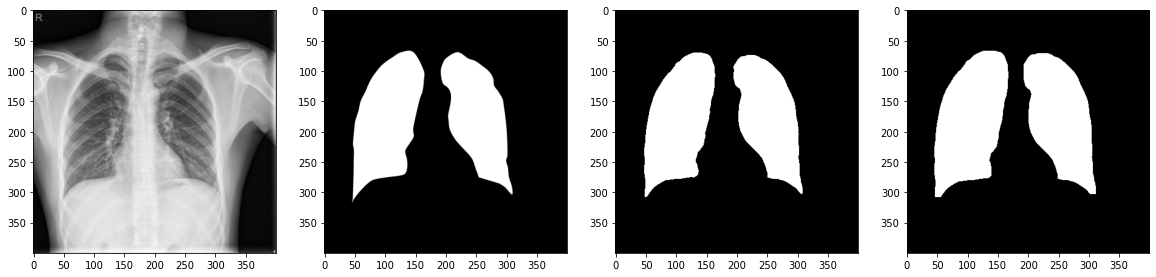

In [14]:
idx = 26

test_img = X_test[idx,:,:,:].reshape((1, img_size, img_size, 1))
test_mask = Y_test[idx,:,:,:].reshape((1, img_size, img_size, 1))
pred_mask = model.predict(test_img)
pred_mask = np.uint8(pred_mask > 0.5)
post_pred_mask = skimage.morphology.erosion(pred_mask[0,:,:,0], skimage.morphology.square(5))
post_pred_mask = skimage.morphology.dilation(post_pred_mask, skimage.morphology.square(10))


f = plt.figure(figsize = (20, 10))
f.add_subplot(1, 4, 1)
plt.imshow(img_as_float64(test_img[0,:,:,0]), cmap = "gray")
f.add_subplot(1, 4, 2)
plt.imshow(test_mask[0,:,:,0], cmap = "gray")
f.add_subplot(1, 4, 3)
plt.imshow(pred_mask[0,:,:,0], cmap = "gray")
f.add_subplot(1, 4, 4)
plt.imshow(post_pred_mask, cmap = "gray")

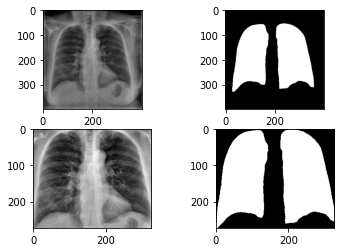

In [15]:
def crop_image(img, mask):
  crop_mask = mask > 0
  m, n = mask.shape
  crop_mask0, crop_mask1 = crop_mask.any(0), crop_mask.any(1)
  col_start, col_end = crop_mask0.argmax(), n - crop_mask0[::-1].argmax()
  row_start, row_end = crop_mask1.argmax(), m - crop_mask1[::-1].argmax()
  return img[row_start:row_end, col_start:col_end], mask[row_start:row_end, col_start:col_end]
  
#idx = 70
idx = 2
test_img = X_test[idx,:,:,:].reshape((1, img_size, img_size, 1))
test_mask = Y_test[idx,:,:,:].reshape((1, img_size, img_size, 1))
pred_mask = model.predict(test_img)[0,:,:,0]
pred_mask = np.uint8(pred_mask > 0.5)
open_pred_mask = skimage.morphology.erosion(pred_mask, skimage.morphology.square(5))
open_pred_mask = skimage.morphology.dilation(open_pred_mask, skimage.morphology.square(5))
post_pred_mask = skimage.morphology.dilation(open_pred_mask, skimage.morphology.square(5))

crop_img, crop_mask = crop_image(test_img[0,:,:,0], pred_mask)

crop_img_masked = crop_img * crop_mask

f = plt.figure()
f.add_subplot(2, 2, 1)
plt.imshow(img_as_float64(test_img[0,:,:,0]), cmap = "gray")
f.add_subplot(2, 2, 2)
plt.imshow(post_pred_mask, cmap = "gray")
f.add_subplot(2, 2, 3)
plt.imshow(img_as_float64(crop_img), cmap = "gray")
f.add_subplot(2, 2, 4)
plt.imshow(crop_mask, cmap = "gray")

[]

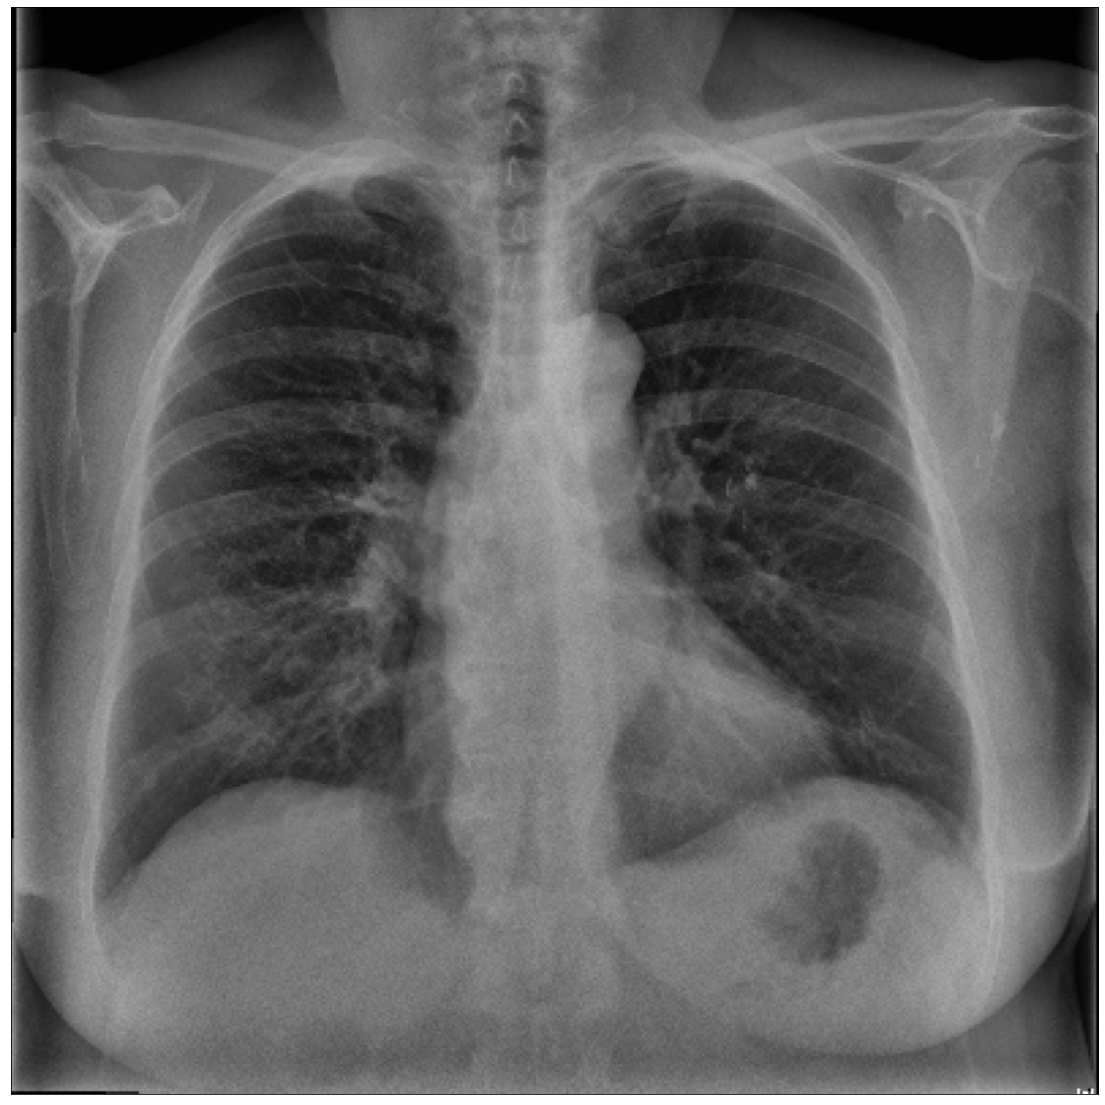

In [16]:
f = plt.figure(figsize = (20, 20))
f.add_subplot(1, 1, 1)
plt.imshow(img_as_float32(test_img[0,:,:,0]), cmap = "gray")
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

[]

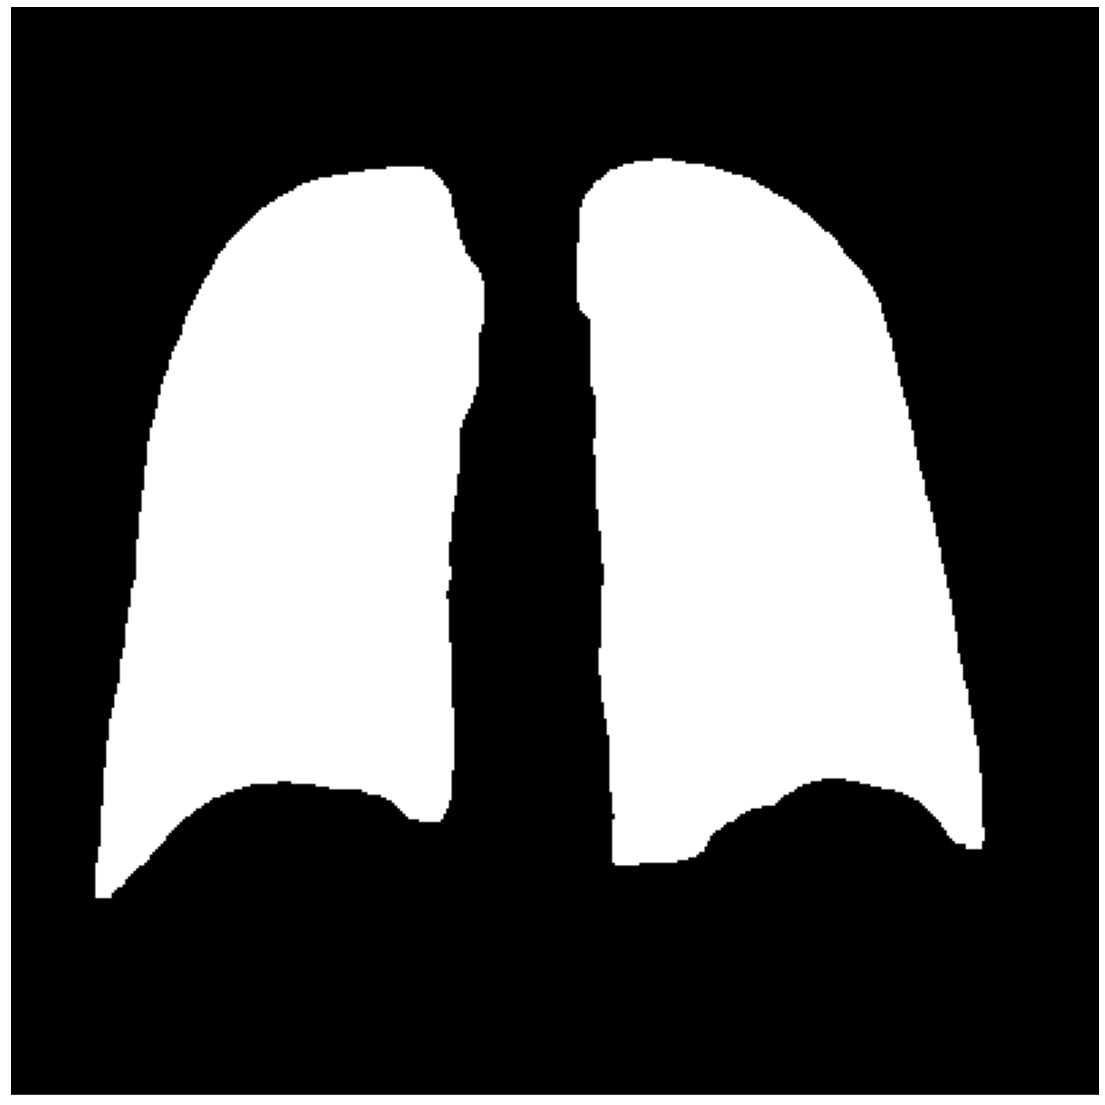

In [17]:
f = plt.figure(figsize = (20, 20))
f.add_subplot(1, 1, 1)
plt.imshow(open_pred_mask, cmap = "gray")
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

[]

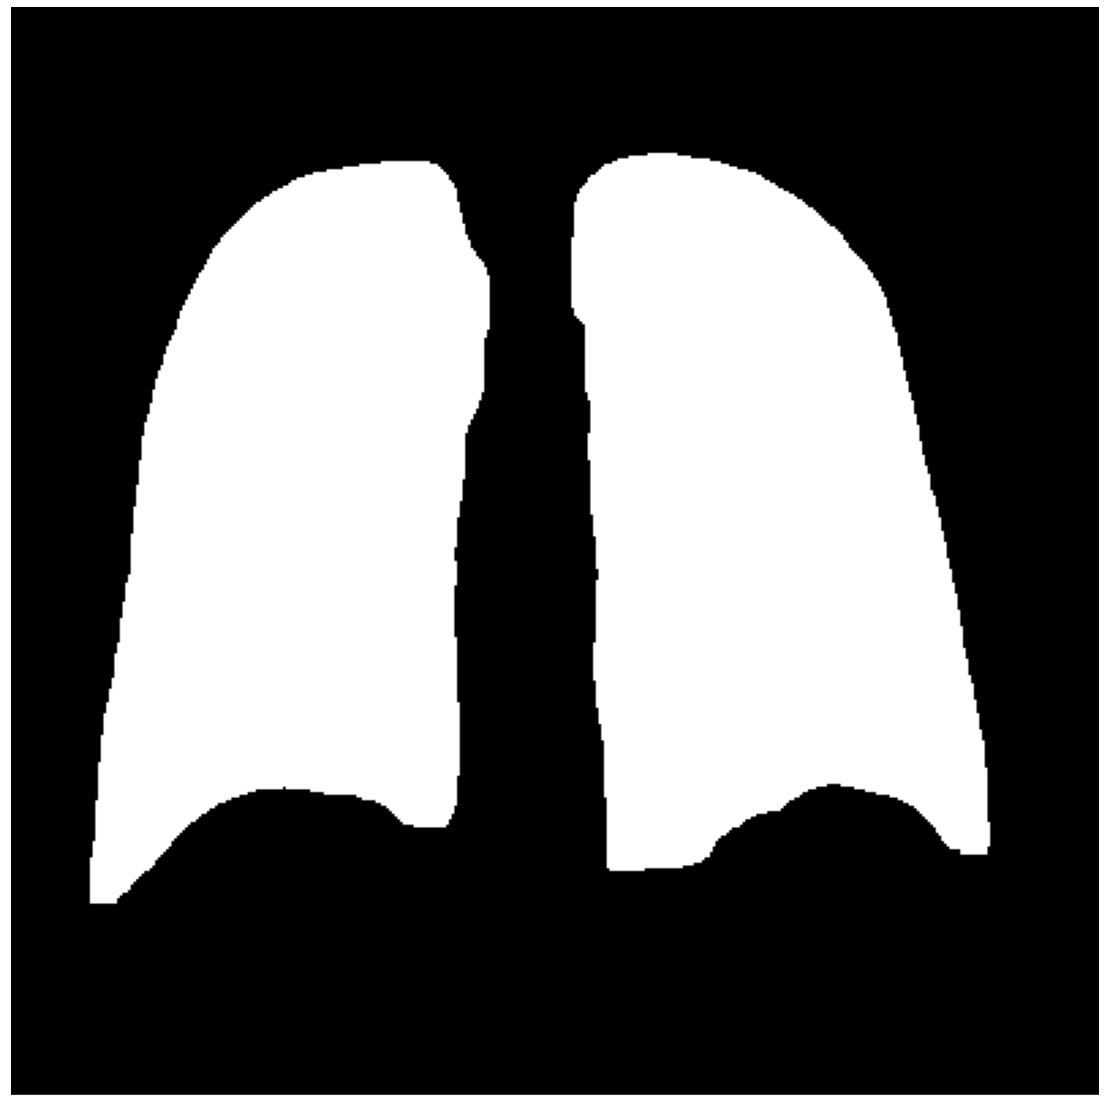

In [18]:
f = plt.figure(figsize = (20, 20))
f.add_subplot(1, 1, 1)
plt.imshow(post_pred_mask, cmap = "gray")
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

[]

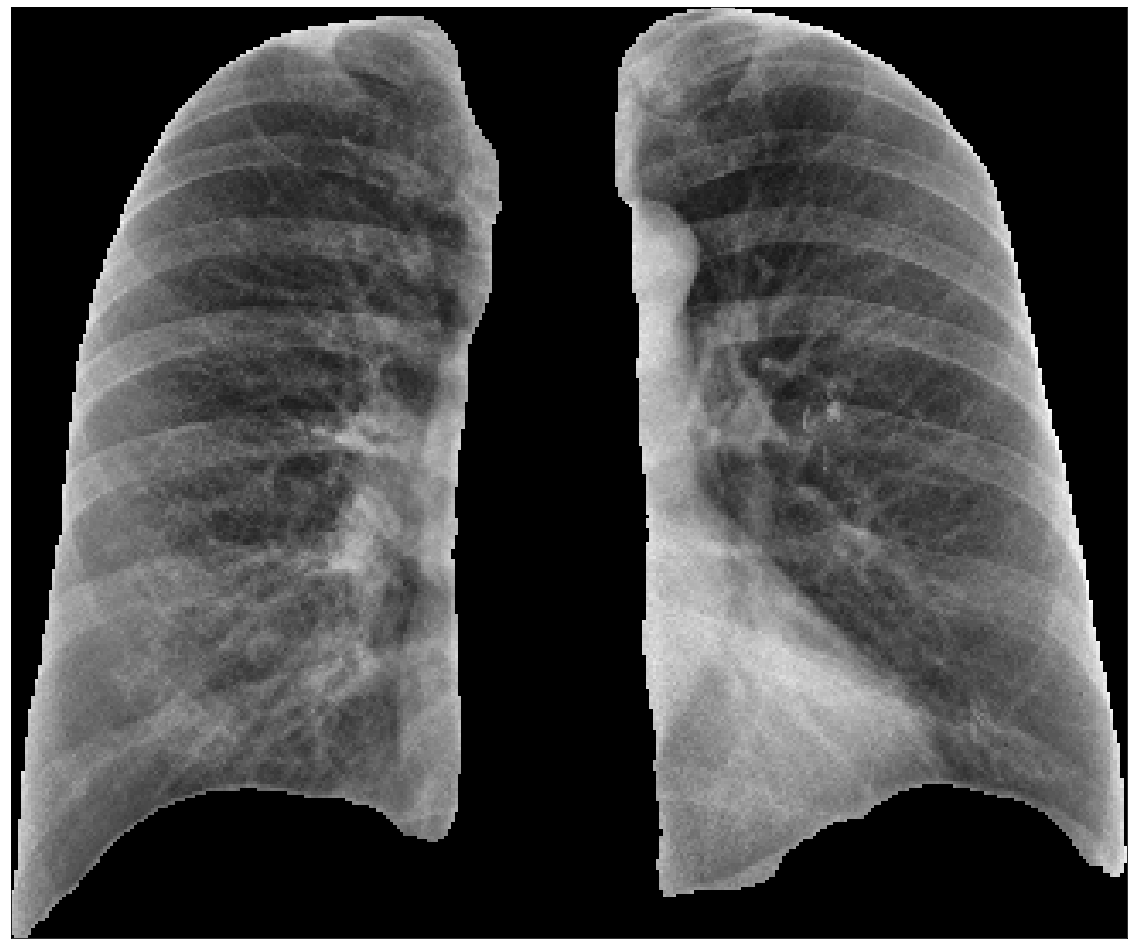

In [19]:
f = plt.figure(figsize = (20, 20))
f.add_subplot(1, 1, 1)
plt.imshow(crop_img_masked, cmap = "gray")
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

# Make Predictions

In [ ]:
source_folders = [ "Cohen", "RSNA", "Actualmed", "Figure1", "KaggleCRD", "RICORD"] #"BIMCV"
pathogen_folders = ["Opacity", "COVID-19", "Normal"]
dest_folder = "2_Images_Seg"
root_folder = "../3_Images/"
masks_folder = os.path.join(root_folder, "masks")

img_size = 400

if os.path.isdir(dest_folder):
  shutil.rmtree(dest_folder)

if not os.path.isdir(dest_folder):
  os.makedirs(dest_folder)
  
if not os.path.isdir(os.path.join(dest_folder, "masks")):
  os.makedirs(os.path.join(dest_folder, "masks"))
  
for target in ["train", "test"]:
  for pathogen in pathogen_folders:
    pathogen_folder = os.path.join(dest_folder, target, pathogen)
    if not os.path.isdir(pathogen_folder):
      os.makedirs(pathogen_folder)

with tf.device("/gpu:0"):
  targets = ["train", "test"]
  for target in targets:
    pathogens = os.listdir(os.path.join(root_folder, target))
    for pathogen in pathogens:
      images = os.listdir(os.path.join(root_folder, target, pathogen))
      for image in images:
        source, _, pid, offset, _ = re.split("[_.]", image)
        img_path = os.path.join(root_folder, target, pathogen, image)
        print(img.shape)
        img = imread(img_path, cv2.IMREAD_GRAYSCALE)
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
        img = img_as_float32(img).reshape((1, img_size, img_size, 1))
        mask_pred = model.predict(img)[0,:,:,0]
        mask_pred = np.uint8(mask_pred > 0.5)
        mask_pred = skimage.morphology.erosion(mask_pred, skimage.morphology.square(5))
        mask_pred = skimage.morphology.dilation(mask_pred, skimage.morphology.square(10))
        img = img_as_ubyte(img[0,:,:,0])

        crop_img, crop_mask = crop_image(img, mask_pred)
        
        mask_filename = "%s_%s_%s_%s_%s.png" % (target, source, pathogen, pid, offset)
        img_filename = "%s_%s_%s_%s.png" % (source, pathogen, pid, offset)

        wdt, hgt = crop_img.shape
        if wdt < 200 or hgt < 200:
          print(img_filename)
          #continue

        crop_img = crop_img * crop_mask

        crop_img = cv2.resize(crop_img, (300, 300), interpolation = cv2.INTER_CUBIC)
        crop_mask = cv2.resize(crop_mask, (300, 300), interpolation = cv2.INTER_CUBIC)

        imsave(os.path.join(dest_folder, "masks", mask_filename), crop_mask * 255)
        imsave(os.path.join(dest_folder, target, pathogen, img_filename), crop_img)

(400, 400, 3)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RICORD_COVID-19_840_1.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
KaggleCRD_COVID-19_274_0.png
(400, 400)
(400, 400)
RICORD_COVID-19_347_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
KaggleCRD_COVID-19_485_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 4

<ipython-input-27-3b8f08af0a62>:60: UserWarning: 2_Images_Seg/masks/train_RICORD_COVID-19_53_0.png is a low contrast image
  imsave(os.path.join(dest_folder, "masks", mask_filename), crop_mask * 255)
<ipython-input-27-3b8f08af0a62>:61: UserWarning: 2_Images_Seg/train/COVID-19/RICORD_COVID-19_53_0.png is a low contrast image
  imsave(os.path.join(dest_folder, target, pathogen, img_filename), crop_img)


(400, 400)
(400, 400)
(400, 400)
RICORD_COVID-19_846_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
KaggleCRD_COVID-19_311_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RICORD_COVID-19_4_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RICORD_COVID-19_66_2.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400,

<ipython-input-27-3b8f08af0a62>:60: UserWarning: 2_Images_Seg/masks/train_RICORD_COVID-19_90_1.png is a low contrast image
  imsave(os.path.join(dest_folder, "masks", mask_filename), crop_mask * 255)
<ipython-input-27-3b8f08af0a62>:61: UserWarning: 2_Images_Seg/train/COVID-19/RICORD_COVID-19_90_1.png is a low contrast image
  imsave(os.path.join(dest_folder, target, pathogen, img_filename), crop_img)


(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RICORD_COVID-19_883_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
KaggleCRD_COVID-19_477_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)

<ipython-input-27-3b8f08af0a62>:60: UserWarning: 2_Images_Seg/masks/train_KaggleCRD_COVID-19_698_0.png is a low contrast image
  imsave(os.path.join(dest_folder, "masks", mask_filename), crop_mask * 255)
<ipython-input-27-3b8f08af0a62>:61: UserWarning: 2_Images_Seg/train/COVID-19/KaggleCRD_COVID-19_698_0.png is a low contrast image
  imsave(os.path.join(dest_folder, target, pathogen, img_filename), crop_img)


(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
KaggleCRD_COVID-19_909_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RICORD_COVID-19_813_0.png
(400, 400)
(400, 400)
RICORD_COVID-19_276_1.png
(400, 400)
(400, 

<ipython-input-27-3b8f08af0a62>:60: UserWarning: 2_Images_Seg/masks/train_KaggleCRD_COVID-19_697_0.png is a low contrast image
  imsave(os.path.join(dest_folder, "masks", mask_filename), crop_mask * 255)
<ipython-input-27-3b8f08af0a62>:61: UserWarning: 2_Images_Seg/train/COVID-19/KaggleCRD_COVID-19_697_0.png is a low contrast image
  imsave(os.path.join(dest_folder, target, pathogen, img_filename), crop_img)


(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RICORD_COVID-19_499_0.png
(400, 400)
(400, 400)
RICORD_COVID-19_551_1.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
Cohen_COVID-19_58_6.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)


<ipython-input-27-3b8f08af0a62>:60: UserWarning: 2_Images_Seg/masks/train_KaggleCRD_COVID-19_604_0.png is a low contrast image
  imsave(os.path.join(dest_folder, "masks", mask_filename), crop_mask * 255)
<ipython-input-27-3b8f08af0a62>:61: UserWarning: 2_Images_Seg/train/COVID-19/KaggleCRD_COVID-19_604_0.png is a low contrast image
  imsave(os.path.join(dest_folder, target, pathogen, img_filename), crop_img)


(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RICORD_COVID-19_613_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
KaggleCRD_COVID-19_303_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RICORD_COVID-19_132_1.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RICORD_COVID-19_201_1.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)


<ipython-input-27-3b8f08af0a62>:60: UserWarning: 2_Images_Seg/masks/train_KaggleCRD_COVID-19_523_0.png is a low contrast image
  imsave(os.path.join(dest_folder, "masks", mask_filename), crop_mask * 255)
<ipython-input-27-3b8f08af0a62>:61: UserWarning: 2_Images_Seg/train/COVID-19/KaggleCRD_COVID-19_523_0.png is a low contrast image
  imsave(os.path.join(dest_folder, target, pathogen, img_filename), crop_img)


(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
Cohen_COVID-19_164_2.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
KaggleCRD_COVID-19_553_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)


(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Normal_1651_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400

(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Normal_1637_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400

(400, 400)
(400, 400)
RSNA_Normal_1150_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Normal_1633_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Normal_1083_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 4

<ipython-input-27-3b8f08af0a62>:60: UserWarning: 2_Images_Seg/masks/train_RSNA_Opacity_7742_0.png is a low contrast image
  imsave(os.path.join(dest_folder, "masks", mask_filename), crop_mask * 255)
<ipython-input-27-3b8f08af0a62>:61: UserWarning: 2_Images_Seg/train/Opacity/RSNA_Opacity_7742_0.png is a low contrast image
  imsave(os.path.join(dest_folder, target, pathogen, img_filename), crop_img)


(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6241_0.png
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6830_0.png
(400, 400)
RSNA_Opacity_6656_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6238_0.png
(400, 400)
(400, 400)
RSNA_Opacity_5854_0.png
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_5942_0.png
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_5705_0.png
(400, 400)
(400, 400)
RSNA_Opacity_7693_0.png
(400, 400)
RSNA_Opacity_6931_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_5969_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(

<ipython-input-27-3b8f08af0a62>:60: UserWarning: 2_Images_Seg/masks/train_RSNA_Opacity_5622_0.png is a low contrast image
  imsave(os.path.join(dest_folder, "masks", mask_filename), crop_mask * 255)
<ipython-input-27-3b8f08af0a62>:61: UserWarning: 2_Images_Seg/train/Opacity/RSNA_Opacity_5622_0.png is a low contrast image
  imsave(os.path.join(dest_folder, target, pathogen, img_filename), crop_img)


(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6718_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6167_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_5612_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6818_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6383_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_7684_0.png
(400, 400)
(400, 400)
RSNA_Opacity_5778_0.png
(400, 400)
(400, 400)
(400, 4

<ipython-input-27-3b8f08af0a62>:60: UserWarning: 2_Images_Seg/masks/train_RSNA_Opacity_7295_0.png is a low contrast image
  imsave(os.path.join(dest_folder, "masks", mask_filename), crop_mask * 255)
<ipython-input-27-3b8f08af0a62>:61: UserWarning: 2_Images_Seg/train/Opacity/RSNA_Opacity_7295_0.png is a low contrast image
  imsave(os.path.join(dest_folder, target, pathogen, img_filename), crop_img)


(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_7650_0.png
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6786_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_7272_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_7635_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6688_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6829_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6297_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6709_0.png
(400,

<ipython-input-27-3b8f08af0a62>:60: UserWarning: 2_Images_Seg/masks/train_RSNA_Opacity_6452_0.png is a low contrast image
  imsave(os.path.join(dest_folder, "masks", mask_filename), crop_mask * 255)
<ipython-input-27-3b8f08af0a62>:61: UserWarning: 2_Images_Seg/train/Opacity/RSNA_Opacity_6452_0.png is a low contrast image
  imsave(os.path.join(dest_folder, target, pathogen, img_filename), crop_img)


(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_5406_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_5335_0.png
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6359_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)


<ipython-input-27-3b8f08af0a62>:60: UserWarning: 2_Images_Seg/masks/train_RSNA_Opacity_5202_0.png is a low contrast image
  imsave(os.path.join(dest_folder, "masks", mask_filename), crop_mask * 255)
<ipython-input-27-3b8f08af0a62>:61: UserWarning: 2_Images_Seg/train/Opacity/RSNA_Opacity_5202_0.png is a low contrast image
  imsave(os.path.join(dest_folder, target, pathogen, img_filename), crop_img)


(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_7763_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6974_0.png
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_5317_0.png
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_7759_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_5797_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_5936_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_5476_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_5211_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400,

<ipython-input-27-3b8f08af0a62>:60: UserWarning: 2_Images_Seg/masks/train_RSNA_Opacity_5292_0.png is a low contrast image
  imsave(os.path.join(dest_folder, "masks", mask_filename), crop_mask * 255)
<ipython-input-27-3b8f08af0a62>:61: UserWarning: 2_Images_Seg/train/Opacity/RSNA_Opacity_5292_0.png is a low contrast image
  imsave(os.path.join(dest_folder, target, pathogen, img_filename), crop_img)


(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6731_0.png
(400, 400)
RSNA_Opacity_7576_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_7332_0.png
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_7602_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)


<ipython-input-27-3b8f08af0a62>:60: UserWarning: 2_Images_Seg/masks/train_RSNA_Opacity_6385_0.png is a low contrast image
  imsave(os.path.join(dest_folder, "masks", mask_filename), crop_mask * 255)
<ipython-input-27-3b8f08af0a62>:61: UserWarning: 2_Images_Seg/train/Opacity/RSNA_Opacity_6385_0.png is a low contrast image
  imsave(os.path.join(dest_folder, target, pathogen, img_filename), crop_img)


(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6438_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_7452_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_5801_0.png
(400, 400)
(400, 400)
RSNA_Opacity_7404_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6502_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_5344_0.png
(400, 400)
RSNA_Opacity_5798_0.png
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_7382_0.png
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_7552_0.png
(400, 400)
(40

<ipython-input-27-3b8f08af0a62>:60: UserWarning: 2_Images_Seg/masks/train_RSNA_Opacity_6567_0.png is a low contrast image
  imsave(os.path.join(dest_folder, "masks", mask_filename), crop_mask * 255)
<ipython-input-27-3b8f08af0a62>:61: UserWarning: 2_Images_Seg/train/Opacity/RSNA_Opacity_6567_0.png is a low contrast image
  imsave(os.path.join(dest_folder, target, pathogen, img_filename), crop_img)


(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_7119_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_5278_0.png
(400, 400)
(400, 400)
RSNA_Opacity_6561_0.png
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_5644_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)


<ipython-input-27-3b8f08af0a62>:60: UserWarning: 2_Images_Seg/masks/train_RSNA_Opacity_6201_0.png is a low contrast image
  imsave(os.path.join(dest_folder, "masks", mask_filename), crop_mask * 255)
<ipython-input-27-3b8f08af0a62>:61: UserWarning: 2_Images_Seg/train/Opacity/RSNA_Opacity_6201_0.png is a low contrast image
  imsave(os.path.join(dest_folder, target, pathogen, img_filename), crop_img)


(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_5968_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6456_0.png
(400, 400)
RSNA_Opacity_5306_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6713_0.png
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6125_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6995_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6563_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6104_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400,

<ipython-input-27-3b8f08af0a62>:60: UserWarning: 2_Images_Seg/masks/train_RSNA_Opacity_5345_0.png is a low contrast image
  imsave(os.path.join(dest_folder, "masks", mask_filename), crop_mask * 255)


(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_7368_0.png
(400, 400)
RSNA_Opacity_6921_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6474_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6825_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_7351_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6595_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6281_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6213_0.png
(400, 400)
(400, 400)
RSNA_Opacity_5366_0.png
(40

(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_7152_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_7369_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_7024_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_7029_0.png
(400, 400)
RSNA_Opacity_6748_0.png
(400, 400)
RSNA_Opacity_5315_0.png
(400, 400)
(400, 400)
RSNA_Opacity_6953_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_7388_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_5516_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
RSNA_Opacity_6622_0.png
(400, 400)
(400, 400)
R

(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
KaggleCRD_COVID-19_574_0.png
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
(400, 400)
